# Predicting Number of Oscar Nominations for a Movie

Topic | Date | Name
-----|------|-----
Explore boxofficemojo data |04/14/2016 |Max Melnick

**Data to collect**
- number of days released befor oscar nominations are announced
- imdb critic rating
- imdb user rating
- actors (not sure how to structure this. maybe # top actors/actresses?)
- collective previous oscar nominations/wins for cast??
- total gross


**Completed**
- production budget
- genre
- international gross
- opening weekend gross
- studio
- \# theaters
- number of nominations
- number of wins

Other ideas:
- optimal years/days to wait to release a sequel
- optimal # weeks to wait to see a popular movie

---

In [143]:
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
import pickle

import requests
from bs4 import BeautifulSoup
import re
from pprint import pprint
import pandas as pd
from pandas import DataFrame
import numpy as np
import datetime
from time import strftime
from math import ceil
from scipy import stats
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid')

from matplotlib.ticker import FuncFormatter

%matplotlib inline

import gevent.monkey
gevent.monkey.patch_socket()
from gevent.pool import Pool

import dateutil.parser

from math import ceil

import omdb
omdb.set_default('tomatoes', True)

from collections import defaultdict

In [2]:
base_url = 'http://boxofficemojo.com'

In [3]:
import time

def timefunc(f):
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        print f.__name__, 'took', end - start, 'seconds'
        return result
    return f_timer

In [4]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.0fM' % (x*1e-6)

formatter = FuncFormatter(millions)

def urlToSoup(url):
    response = requests.get(url)
    return BeautifulSoup(response.text, 'lxml')

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

def money_to_int(moneystring):
    try:
        moneystring = moneystring.replace(' (Estimate)', '')
        moneystring = moneystring.replace('$', '').replace(',', '')
        return int(moneystring)
    except:
        return None

def runtime_to_minutes(runtimestring):
    try:
        runtime = runtimestring.split()
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def budgetToInt(budget_string):
    if not budget_string:
        return None
    
    budget_list = budget_string.replace('$','').split(' ')
    # when the movie budget is a string in form $XX million
    if len(budget_list) > 1:
        budget = int(float(budget_list[0])*1000000)
        return budget
    # when budget is a string like $100,000
    elif budget_list[0].lower() != 'n/a':
        budget = budget_list[0].replace(',','')
        return money_to_int(budget)
    # when budget is a string == 'N/A' or not listed
    else:
        return None

def getNumTheaters(raw_theater_string):
    theater_string = str(raw_theater_string)
    theater_string = re.search('(\d+,?\d+)+ theaters', theater_string)
    if theater_string:
        theater_string = theater_string.group(0).replace(',','').split(' ')
        return int(theater_string[0])
    else:
        return None
        

def get_movie_value(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    in_box_content = obj.find_parents(class_='mp_box_content')
    if in_box_content:
        return getBoxContent(obj)
    else:
        return getHeadTableContent(obj)
    

def getHeadTableContent(obj):
    next_sibling = obj.findNextSibling()
    parent_sibling = obj.find_parent().findNextSibling()
    if next_sibling:
        return next_sibling.text 
    elif parent_sibling:
        return parent_sibling.text
    else:
        return None
    
def getBoxContent(obj):
    next_td = obj.find_parent('td').find_next_sibling('td')
    if next_td:
        return next_td.get_text(strip=True)
    else:
        return getNumTheaters(obj)

def getSingleMovieData(soup_and_url):
    url = soup_and_url['url']
    soup = soup_and_url['soup']
    
    #create a blank dictionary that will be used to track the movie data
    movie_data = {}
    
    movie_data['url'] = url
    
    #get the movie director and add it to `movie_data` dictionary
    movie_data['director'] = get_movie_value(soup, 'Director')
    
    #get the movie title
    title_string = soup.find('title').text
    title = title_string.split('(2')[0].strip()
    movie_data['title'] = title
    
    #get the release date
    raw_release_date = get_movie_value(soup,'Release Date')
    try: 
        movie_data['release_date'] = to_date(raw_release_date)
    except:
        print ('issues parsing release date for this url', url)
    
    #get the domestic total gross
    raw_domestic_total_gross = get_movie_value(soup,'Domestic Total')
    movie_data['domestic_total_gross'] = money_to_int(raw_domestic_total_gross)
    
    # foreign gross
    movie_data['foreign_total_gross'] = money_to_int(get_movie_value(soup, 'Foreign:'))
    
    #get the MPAA rating
    movie_data['rating'] = get_movie_value(soup,'MPAA Rating')
    
    # get runtime and convert it to an int
    raw_runtime = get_movie_value(soup,'Runtime')
    movie_data['runtime'] = runtime_to_minutes(raw_runtime)
    
    # get genre
    movie_data['genre'] = get_movie_value(soup,'Genre:')

    # get production budget
    raw_budget = get_movie_value(soup,'Production Budget')    
    movie_data['budget'] = budgetToInt(raw_budget)
    
    # opening weekend
    movie_data['opening_weekend_gross'] = money_to_int(get_movie_value(soup, 'Weekend:'))
    
    # studio
    movie_data['studio'] = get_movie_value(soup, 'Distributor:')
    
    # num opening weekend theaters
    movie_data['num_opening_theaters'] = get_movie_value(soup, 'theaters,')
    
    return movie_data

def getHrefFromATags(a_tag_list):
    links = []
    for link in a_tag_list:
        links.append(base_url+link.get('href'))
    
    return links

def getMovieLinks(year_list):
    #generate the urls that we'll scrape for each year on boxofficemojo.com
    year_urls = []
    for year in year_list:
        top_hundred_url = 'http://www.boxofficemojo.com/yearly/chart/?yr='+year+'&p=.htm'
        year_urls.append(top_hundred_url)
        year_urls += getMoreLinksForOneYear(top_hundred_url)
        
    links_to_movies = []
    for url in year_urls:
        links_to_movies += urlToSoup(url).find(id='body').find_all('a', href=re.compile('^/movies/\?id'))
    
    links = getHrefFromATags(links_to_movies)
    return links

def getMoreLinksForOneYear(url):
    top_hundreds = urlToSoup(url).find('center').find_all('a', href=re.compile('^/yearly/chart/'))
    return getHrefFromATags(top_hundreds)

#getMovieLinks(['2013'])

In [5]:
@timefunc
def getAllMovieDataSlow(year_list):
    links_to_movies = getMovieLinks(year_list)

    data = []
    for url in links_to_movies:
        soup = urlToSoup(url)
        movie_data = getSingleMovieData({'url': url, 'soup': soup})
        data.append(movie_data)
    return DataFrame(data).set_index('title')

def fetchSoup(url):
    soup = urlToSoup(url)
    # some urls we collect are broken. Check if they're broken and filter them out if they are
    # (e.g., http://boxofficemojo.com/movies/?id=prophet'sprey.htm is a broken link)
    checkInvalidUrl = soup.find('center', text=re.compile('Invalid Movie ID Specified.'))
    if not checkInvalidUrl:
        return {'url': url, 'soup': soup}
    else:
        return None

def getMovieSoups(urls):
    pool = Pool(25)
    soup_and_urls = []
    for url in urls:
        soup_and_url = pool.spawn(fetchSoup, url)
        soup_and_urls.append(soup_and_url)
    pool.join()
    return soup_and_urls

@timefunc
def getAllMovieData(year_list):
    links_to_movies = getMovieLinks(year_list)
    
    movie_soups = getMovieSoups(links_to_movies)
    
    data = []
    for movie_soup in movie_soups:
        val = movie_soup.value
        if val:
            movie_data = getSingleMovieData(val)
            data.append(movie_data)
    return DataFrame(data).set_index('title')

In [6]:
def parseOscarTable(soup):
    table = soup.find('table', bgcolor='#e6ado2')
    table_rows = table.find_all('tr')
    #get rid of the header row
    table_rows.pop(0)
    data = []
    for row in table_rows:
        oscar_data = {}
        columns = row.find_all('td')
        oscar_data['title'] = columns[2].get_text(strip=True)
        oscar_data['noms'] = columns[5].get_text(strip=True)
        oscar_data['wins'] = columns[6].get_text(strip=True)
        data.append(oscar_data)
    return data

# return a DataFrame with Oscar nominations and wins by movie
def getOscarData(year_list):
    year_urls = []
    for year in year_list:
        year_urls.append('http://www.boxofficemojo.com/oscar/chart/?view=allmovies&yr='+year+'&p=.htm')
    
    oscar_data = []
    for url in year_urls:
        soup = urlToSoup(url)
        oscar_data += parseOscarTable(soup)
        
    return DataFrame(oscar_data).set_index('title')

In [7]:
#list the years that we want to get data for the top 100 movies of each year
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', 
         '2009', '2010', '2011', '2012', '2013','2014','2015']
#years = ['2012', '2013']

step = 2
years_separated = [years[i:i+step] for i in range(0, len(years), step)]
print years_separated

[['2000', '2001'], ['2002', '2003'], ['2004', '2005'], ['2006', '2007'], ['2008', '2009'], ['2010', '2011'], ['2012', '2013'], ['2014', '2015']]


In [8]:
#movie_df2 = getAllMovieDataSlow(years)

movie_dfs = []
for year_list in years_separated:
    movie_dfs.append(getAllMovieData(year_list))

getAllMovieData took 53.4537439346 seconds
getAllMovieData took 75.6149029732 seconds
('issues parsing release date for this url', 'http://boxofficemojo.com/movies/?id=mymotherlikeswomen.htm')
('issues parsing release date for this url', 'http://boxofficemojo.com/movies/?id=freestyle.htm')
getAllMovieData took 81.1483530998 seconds
getAllMovieData took 88.0535829067 seconds
getAllMovieData took 103.395069122 seconds
getAllMovieData took 104.069082975 seconds
getAllMovieData took 109.244138956 seconds
('issues parsing release date for this url', 'http://boxofficemojo.com/movies/?id=court\x0b.htm')
getAllMovieData took 132.564718962 seconds


In [9]:
movie_df = pd.concat(movie_dfs)

In [10]:
oscar_df = getOscarData(years)

In [105]:
df = movie_df.join(oscar_df)

In [106]:
#df['noms'].fillna(0)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9069 entries, $9.99 to whaledreamers
Data columns (total 14 columns):
budget                   2237 non-null float64
director                 2924 non-null object
domestic_total_gross     9066 non-null float64
foreign_total_gross      4477 non-null float64
genre                    9066 non-null object
num_opening_theaters     3994 non-null float64
opening_weekend_gross    8615 non-null float64
rating                   9066 non-null object
release_date             9066 non-null datetime64[ns]
runtime                  8737 non-null float64
studio                   9066 non-null object
url                      9069 non-null object
noms                     616 non-null object
wins                     616 non-null object
dtypes: datetime64[ns](1), float64(6), object(7)
memory usage: 1.0+ MB


In [108]:
df.head()

,budget,director,domestic_total_gross,foreign_total_gross,genre,num_opening_theaters,opening_weekend_gross,rating,release_date,runtime,studio,url,noms,wins
title,,,,,,,,,,,,,,
$9.99,NaN,None,52384.0,655970.0,Animation,NaN,478.0,R,2008-12-12,78.0,Regent Releasing,http://boxofficemojo.com/movies/?id=9dot99.htm,NaN,NaN
$upercapitalist,NaN,None,15919.0,NaN,Thriller,NaN,8372.0,Unrated,2012-08-10,96.0,Truly Indie,http://boxofficemojo.com/movies/?id=supercapit...,NaN,NaN
'71,NaN,None,1270847.0,355000.0,War Drama,NaN,55761.0,R,2015-02-27,99.0,Roadside Attractions,http://boxofficemojo.com/movies/?id=71.htm,NaN,NaN
'N Sync: Bigger Than Live (IMAX),NaN,None,1808679.0,NaN,IMAX,NaN,NaN,Unrated,2001-02-02,47.0,IMAX,http://boxofficemojo.com/movies/?id=nsyncimax.htm,NaN,NaN
'R Xmas,NaN,None,850.0,NaN,Unknown,NaN,850.0,R,2002-11-08,83.0,Pathfinder,http://boxofficemojo.com/movies/?id=rxmas.htm,NaN,NaN


In [109]:
df.to_pickle('movie_df_with_oscars.pickle')

In [121]:
def convertToDayOfYear(datetime_obj):
    '''
    takes a date and returns the numeric day of the year as an int
    http://stackoverflow.com/questions/620305/convert-year-month-day-to-day-of-year-in-python
    '''
    return datetime_obj.timetuple().tm_yday

def cleanAndTransformData(df):
    '''
    Take a dataframe and return a new dataframe with necessary cleaning and
    transformations to movie data.
    '''
    transformed_df = df
    
    # TODO: analyze what data was excluded
    
    transformed_df = transformed_df.dropna(subset=['release_date', 'runtime', 'opening_weekend_gross'], how='any')
    
    # create new columns for nominations and wins and fill NaN with 0
    transformed_df.loc[:, 'noms_adj'] = transformed_df.loc[:,'noms'].fillna(0).astype('int')
    #transformed_df.loc[:, 'wins_adj'] = transformed_df.loc[:,'wins'].fillna(0).astype('int')
    
    transformed_df.loc[:, 'day_of_year'] = transformed_df.loc[:,'release_date'].map(convertToDayOfYear)
    
    transformed_df = transformed_df.drop(['noms', 'wins', 'url', 'genre', 'director', 'rating', 'studio', 'release_date',
                 'foreign_total_gross', 'budget', 'num_opening_theaters'], 1)
    
    # TODO: adjust for inflation
    
    return transformed_df

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9069 entries, $9.99 to whaledreamers
Data columns (total 14 columns):
budget                   2237 non-null float64
director                 2924 non-null object
domestic_total_gross     9066 non-null float64
foreign_total_gross      4477 non-null float64
genre                    9066 non-null object
num_opening_theaters     3994 non-null float64
opening_weekend_gross    8615 non-null float64
rating                   9066 non-null object
release_date             9066 non-null datetime64[ns]
runtime                  8737 non-null float64
studio                   9066 non-null object
url                      9069 non-null object
noms                     616 non-null object
wins                     616 non-null object
dtypes: datetime64[ns](1), float64(6), object(7)
memory usage: 1.0+ MB


In [122]:
clean_df = cleanData(df)

df_transformed = cleanAndTransformData(clean_df)

df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8330 entries, $9.99 to whaledreamers
Data columns (total 5 columns):
domestic_total_gross     8330 non-null float64
opening_weekend_gross    8330 non-null float64
runtime                  8330 non-null float64
noms_adj                 8330 non-null int64
day_of_year              8330 non-null int64
dtypes: float64(3), int64(2)
memory usage: 390.5+ KB


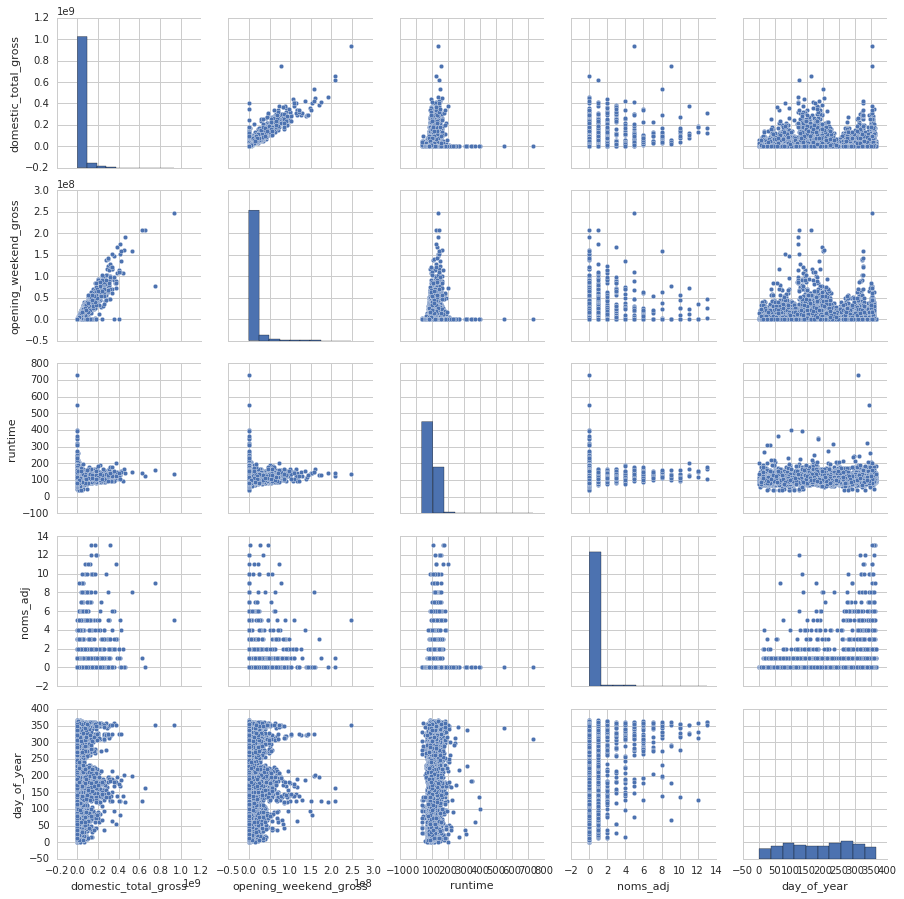

In [123]:
sns.pairplot(df_transformed)

In [129]:
def runModel(X,y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y)
    print X_train.shape, X_test.shape, Y_train.shape, Y_test.shape
    model = sm.OLS(Y_train, X_train) 
    results = model.fit()
    return results

In [133]:
X = df_transformed.drop('noms_adj', 1)
y = df_transformed['noms_adj']

results = runModel(X,y)

results.summary()

(6247, 4) (2083, 4) (6247,) (2083,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               noms_adj   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     788.6
Date:                Tue, 19 Apr 2016   Prob (F-statistic):               0.00
Time:                        21:29:36   Log-Likelihood:                -7429.3
No. Observations:                6247   AIC:                         1.487e+04
Df Residuals:                    6243   BIC:                         1.489e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
domestic_total_gross   2.755e-08   5.71e-10     48.243      0.000      2.64e-08  2.87e-08
opening_weekend_gross -7.424e-08    1.9e-09    -39.174      0.000      -7.8e-08 -7.05e-08
runtime                3.224e-05      0.000      0.163      0.870        -0.000     0.000
day_of_year               0.0005   9.62e-05      5.152      0.000         0.000     0.001
==============================================================================
Omnibus:                     6485.551   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           688108.263
Skew:                           4.989   Prob(JB):                         0.00
Kurtosis:                      53.439   Cond. No.                     1.14e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [183]:
def getOMDBDataForTitle(bomj_title):
    res = omdb.search(bomj_title)
    if res:
        title = res[0].title
        movie = omdb.title(title)
        data = movie.items()
        data.append(('bomj_title', bomj_title))
        return dict(data)
    else:
        return None

def getAllOMDBData(titles):
    omdb_data = []
    no_match = []
    for title in titles:
        print title
        data = getOMDBDataForTitle(title)
        if data:
            omdb_data.append(data)
        else:
            no_match.append(title)
    return DataFrame(omdb_data), no_match

In [184]:
movies = df.query('release_date >= "2010-01-01"')

titles = movies_2015.index[:500]

assert len(titles) == 500

In [185]:
omdb_df, no_match = getAllOMDBData(titles)

'71
10 Days in a Madhouse
10,000 Km
1001 Grams
1915
20 Once Again
2015 Oscar Nominated Short Films
3 1/2 Minutes, 10 Bullets
3 Hearts
3 Nights in the Desert
45 Years
5 Flights Up
5 to 7
7 Chinese Brothers
90 Minutes in Heaven
99 Homes
A Ballerina's Tale
A Borrowed Identity
A Brilliant Young Mind
A Fool (Yi ge shao zi)
A Hard Day
A Journey Through Time with Anthony
A LEGO Brickumentary
A La Mala
A Little Chaos
A Pigeon Sat on a Branch Reflecting on Existence
A Poem Is a Naked Person
A Reason
A Royal Night Out
A Walk in the Woods
ABCD (Any Body Can Dance) 2
About Elly
Above and Beyond
Adult Beginners
After The Ball
Against the Sun
All Things Must Pass
Alleluia
Aloft
Aloha
Along the Roadside
Alvin and the Chipmunks: The Road Chip
American Ultra
Americons
Amira & Sam
Amour Fou
Amy
An Honest Liar
Animals
Anita Ho
Anomalisa
Ant-Man
Antarctic Edge
Appropriate Behavior
Arabian Nights: Volume 1 - The Restless One
Arabian Nights: Volume 2 - The Desolate One
Arabian Nights: Volume 3 - The Enchant

In [188]:
pprint(no_match)

[u'10,000 Km',
 u'20 Once Again',
 u'3 1/2 Minutes, 10 Bullets',
 u'A Fool (Yi ge shao zi)',
 u'A Journey Through Time with Anthony',
 u'ABCD (Any Body Can Dance) 2',
 u'Appropriate Behavior',
 u'Arabian Nights: Volume 1 - The Restless One',
 u'Arabian Nights: Volume 2 - The Desolate One',
 u'Arabian Nights: Volume 3 - The Enchanted One',
 u'Back to the Future Day',
 u'Black Souls (Anime Nere)',
 u'Boy and the World',
 u'Brothers: Blood Against Blood',
 u'Devil and Angel (E Gun Tian Shi)',
 u"Don't Think I've Forgotten: Cambodia's Lost Rock and Roll",
 u'Drunk Stoned Brilliant Dead: The Story of the National Lampoon',
 u'Felix and Meira',
 u'Forbidden Games (1952)',
 u'From Mayerling to Sarajevo',
 u'Game of Thrones (IMAX)',
 u'Gangnam 1970',
 u'Go Away Mr. Tumor',
 u'Hamari Adhuri Kahani',
 u'I',
 u"It's All So Quiet (Boven is het stil)",
 u"Jafar Panahi's Taxi",
 u"Kahlil Gibran's The Prophet",
 u"Kahlil Gibran's The Prophet (Gathr)",
 u'Love Forecast',
 u'Love and Lost (Shi Gu)',
 u

In [187]:
omdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 35 columns):
actors                 462 non-null object
awards                 462 non-null object
bomj_title             462 non-null object
box_office             462 non-null object
country                462 non-null object
director               462 non-null object
dvd                    462 non-null object
genre                  462 non-null object
imdb_id                462 non-null object
imdb_rating            462 non-null object
imdb_votes             462 non-null object
language               462 non-null object
metascore              462 non-null object
plot                   462 non-null object
poster                 462 non-null object
production             462 non-null object
rated                  462 non-null object
released               462 non-null object
response               462 non-null object
runtime                462 non-null object
title                  462 non-null